In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms



# 1. Define the path to your data
# Make sure this matches where you extracted the files in Phase 2


DATA_DIR = '/home/yamengc2/Brain-MRI-Segmentation/data/kaggle_3m'

# 2. Get a list of all image paths
# The dataset has folders per patient, so we use recursive search
# We filter out files that have '_mask' in the name because those are targets, not inputs.
image_paths = []
for dirpath, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:
        if 'mask' not in filename and filename.endswith('.tif'):
            image_paths.append(os.path.join(dirpath, filename))

print(f"Total images found: {len(image_paths)}")

Total images found: 3929


In [2]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch

# 1. Redefine the class using PIL (No OpenCV)
class BrainTumorDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Path handling
        img_path = self.image_paths[idx]
        mask_path = img_path.replace('.tif', '_mask.tif')

        # Load with PIL instead of cv2
        # 'RGB' for images, 'L' for grayscale masks
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L') 

        # Apply transformations
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

# 2. Re-initialize the transform and dataset
# Note: transforms.ToTensor() automatically scales images to [0.0, 1.0]
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)) 
])

# Re-create the dataset object
dataset = BrainTumorDataset(image_paths, transform=data_transform)

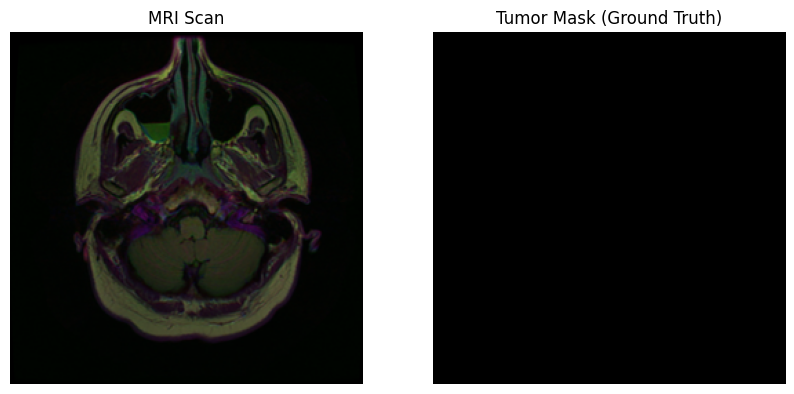

In [3]:
# Create a loader to grab a batch of 16 images
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Get one batch
images, masks = next(iter(dataloader))

# Plot the first image in the batch
plt.figure(figsize=(10, 5))

# Original MRI
plt.subplot(1, 2, 1)
plt.imshow(images[0].permute(1, 2, 0)) # Permute needed because PyTorch is (C, H, W) but Plot expects (H, W, C)
plt.title("MRI Scan")
plt.axis("off")

# Ground Truth Mask
plt.subplot(1, 2, 2)
plt.imshow(masks[0].permute(1, 2, 0), cmap='gray')
plt.title("Tumor Mask (Ground Truth)")
plt.axis("off")

plt.show()

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(Conv2d => BatchNorm => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # --- Encoder (Going Down) ---
        self.dconv_down1 = DoubleConv(3, 64)
        self.dconv_down2 = DoubleConv(64, 128)
        self.dconv_down3 = DoubleConv(128, 256)
        self.dconv_down4 = DoubleConv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        
        # --- Decoder (Going Up) ---
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = DoubleConv(256 + 512, 256)
        self.dconv_up2 = DoubleConv(128 + 256, 128)
        self.dconv_up1 = DoubleConv(64 + 128, 64)
        
        # Output layer (1 channel for the mask)
        self.conv_last = nn.Conv2d(64, 1, 1)
        
    def forward(self, x):
        # 1. Downsampling path
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        # Bottom of the U
        x = self.dconv_down4(x)
        
        # 2. Upsampling path (with Skip Connections)
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1) # Concatenate skip connection
        x = self.dconv_up3(x)

        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       
        x = self.dconv_up2(x)

        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Move model to device
model = UNet().to(device)

Using device: cuda


In [5]:
# 1. Define Dice Loss
def dice_loss(pred, target, smooth=1.):
    pred = torch.sigmoid(pred) # Normalize output to 0-1
    pred = pred.view(-1)       # Flatten
    target = target.view(-1)   # Flatten
    
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    
    return 1 - dice

# 2. Define Optimizer
# Adam is the standard optimizer for U-Nets
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [6]:
num_epochs = 5
print("Starting Training...")

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)
        
        # 1. Forward pass
        outputs = model(images)
        
        # 2. Calculate loss
        loss = dice_loss(outputs, masks)
        
        # 3. Backward pass & optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader):.4f}")

print("Training Complete!")

Starting Training...
Epoch 1/5, Loss: 0.9325
Epoch 2/5, Loss: 0.8047
Epoch 3/5, Loss: 0.6182
Epoch 4/5, Loss: 0.5236
Epoch 5/5, Loss: 0.4996
Training Complete!


In [10]:
from torch.utils.data import random_split

# 1. Re-initialize the full dataset
full_dataset = BrainTumorDataset(image_paths, transform=data_transform)

# 2. Split into Train (80%) and Validation (20%)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# 3. Create DataLoaders for both
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

print(f"Full Training: {len(train_dataset)} images")
print(f"Full Validation: {len(val_dataset)} images")

Full Training: 3143 images
Full Validation: 786 images


In [11]:
import time

# Hyperparameters
num_epochs = 20  # A good standard for U-Net
best_val_loss = float('inf') # Track the best score
save_path = "unet_brain_mri.pth"

print(f"Starting training on {device}...")
start_time = time.time()

for epoch in range(num_epochs):
    
    # --- Training Phase ---
    model.train()
    train_loss = 0
    
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward & Backward
        outputs = model(images)
        loss = dice_loss(outputs, masks)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    
    # --- Validation Phase (No Gradient Calculation) ---
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = dice_loss(outputs, masks)
            val_loss += loss.item()
            
    avg_val_loss = val_loss / len(val_loader)
    
    # --- Progress Report & Saving ---
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    
    # Save the model if it's the best one so far
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), save_path)
        print(f"  >>> Improved! Model saved to {save_path}")

total_time = (time.time() - start_time) / 60
print(f"Training Complete in {total_time:.1f} minutes.")
print(f"Best Validation Loss: {best_val_loss:.4f}")

Starting training on cuda...
Epoch 1/20 | Train Loss: 0.4611 | Val Loss: 0.5108
  >>> Improved! Model saved to unet_brain_mri.pth
Epoch 2/20 | Train Loss: 0.4569 | Val Loss: 0.4778
  >>> Improved! Model saved to unet_brain_mri.pth
Epoch 3/20 | Train Loss: 0.4357 | Val Loss: 0.4960
Epoch 4/20 | Train Loss: 0.4598 | Val Loss: 0.4731
  >>> Improved! Model saved to unet_brain_mri.pth
Epoch 5/20 | Train Loss: 0.4264 | Val Loss: 0.4404
  >>> Improved! Model saved to unet_brain_mri.pth
Epoch 6/20 | Train Loss: 0.4345 | Val Loss: 0.4421
Epoch 7/20 | Train Loss: 0.4229 | Val Loss: 0.4098
  >>> Improved! Model saved to unet_brain_mri.pth
Epoch 8/20 | Train Loss: 0.4194 | Val Loss: 0.4466
Epoch 9/20 | Train Loss: 0.4183 | Val Loss: 0.3948
  >>> Improved! Model saved to unet_brain_mri.pth
Epoch 10/20 | Train Loss: 0.4165 | Val Loss: 0.3923
  >>> Improved! Model saved to unet_brain_mri.pth
Epoch 11/20 | Train Loss: 0.4468 | Val Loss: 0.4940
Epoch 12/20 | Train Loss: 0.5293 | Val Loss: 0.5045
Epoch 

In [12]:
# Load the best weights we saved
model.load_state_dict(torch.load("unet_brain_mri.pth"))
model.eval()

# Now run your visualization code from the previous step!

UNet(
  (dconv_down1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (dconv_down2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (dconv_down3): DoubleConv(
    (double_conv): Sequential

In [13]:
def calculate_metrics(loader, model):
    model.eval()
    total_dice = 0
    num_batches = 0
    
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            
            # Calculate Dice Score (1 - Dice Loss)
            loss = dice_loss(outputs, masks)
            dice_score = 1 - loss.item()
            
            total_dice += dice_score
            num_batches += 1
            
    return total_dice / num_batches

# Calculate score on the Validation Set (Unseen data)
val_score = calculate_metrics(val_loader, model)
print(f"Final Dice Score on Validation Set: {val_score:.4f}")

Final Dice Score on Validation Set: 0.6077


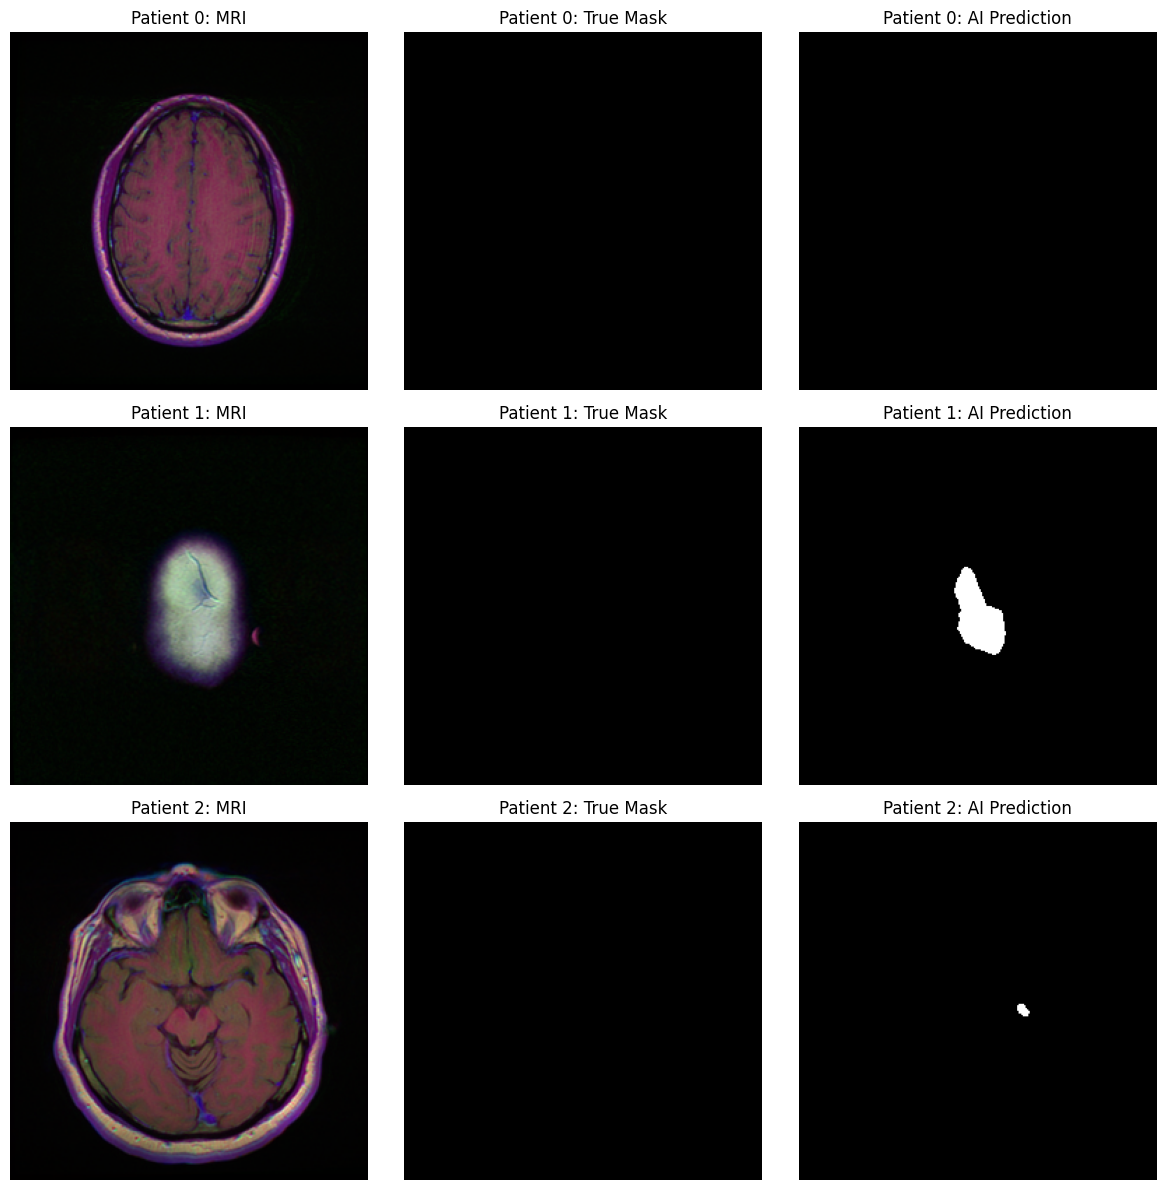

In [ ]:
# Get a batch from the validation loader
images, masks = next(iter(val_loader))
images = images.to(device)

# Get predictions
with torch.no_grad():
    preds = model(images)
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float() # Threshold

# Plot 3 random samples from the batch
fig, axes = plt.subplots(5, 5, figsize=(12, 12))

# Select 3 indices to plot
indices = [0, 1, 2] # You can change these to see different patients

for i, idx in enumerate(indices):
    # 1. Original MRI
    axes[i, 0].imshow(images[idx].cpu().permute(1, 2, 0))
    axes[i, 0].set_title(f"Patient {idx}: MRI")
    axes[i, 0].axis("off")
    
    # 2. Ground Truth
    axes[i, 1].imshow(masks[idx].cpu().permute(1, 2, 0), cmap='gray')
    axes[i, 1].set_title(f"Patient {idx}: True Mask")
    axes[i, 1].axis("off")
    
    # 3. Prediction
    axes[i, 2].imshow(preds[idx].cpu().permute(1, 2, 0), cmap='gray')
    axes[i, 2].set_title(f"Patient {idx}: AI Prediction")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.savefig("final_validation_results.png") # Saves the file
plt.show()